In [6]:
import numpy as np
import scipy as sp
import pandas as pd
import random
import matplotlib.pyplot as plt
import  networkx as nx
import tensorflow as tf

%matplotlib inline

The non backtacking matrix is similiar to message passing algorithms used to find clusters.  This works much better in the sparse case (especially since adjacency matrices in that case are very not full rank, so finding their eigenvectors...)

Definition:

Let M be the number of edges, then the matrix B, our non backtracking matrix will be a 2M by 2M matrix such that B_(ei-ej) = 1 if ei and ej are adjacent and are not just one edge, and 0 otherwise (i.e the diagonal should be zero). 


An interesting point is that the Bethe Hessian matrix should have similar performance, however is defined from the laplacian, with a regularizing r...that can be learned.  https://papers.nips.cc/paper/5520-spectral-clustering-of-graphs-with-the-bethe-hessian.pdf

the Bethe Hessian Matrix is the deformed Laplacian is is simply:
H(r): = (r^2 -1)1 - rA +D


for the stochastic block model, optimal r's have been show to equal root(c) where c is the average degree of the graph.


Compute eigenvectors associated with negative eigenvalues of both H(r_c) and H(-r_c)

supposedly, the negative eigenvalues of H(r_c) reveal the assortative aspects, whereas H(-r_c) reviews the disassortative ones.

Tests:

Give a large dataset of stochastic block models with the same average degree, will it learn the correct r_c?



ß

In [2]:
def balanced_stochastic_blockmodel(communities=2, groupsize=3, p_in=1.0, p_out=0.0):
    #gives dense adjacency matrix representaiton of randomly generated SBM with balanced community size

    G = nx.planted_partition_graph(l=communities, k=groupsize, p_in=p_in, p_out =p_out)
    A = nx.adjacency_matrix(G).todense()
    
    return A


communities = 2 #number of communities, chance to 
group_size = 4 #number of nodes in each communitites (balanced so far)
dim_graph = communities*group_size
A = balanced_stochastic_blockmodel(communities=communities, groupsize=group_size, p_in=0.15, p_out=0.01)
print A

[[0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [3]:
#create a dataset
block_model = [balanced_stochastic_blockmodel() for i in range(9)]



In [4]:
def gather_cols(params, indices, name=None):
    """Gather columns of a 2D tensor.

    Args:
        params: A 2D tensor.
        indices: A 1D tensor. Must be one of the following types: ``int32``, ``int64``.
        name: A name for the operation (optional).

    Returns:
        A 2D Tensor. Has the same type as ``params``.
    """
    with tf.name_scope(name, "gather_cols", [params, indices]) as scope:
        # Check input
        params = tf.convert_to_tensor(params, name="params")
        indices = tf.convert_to_tensor(indices, name="indices")
        try:
            params.get_shape().assert_has_rank(2)
        except ValueError:
            raise ValueError('\'params\' must be 2D.')
        try:
            indices.get_shape().assert_has_rank(1)
        except ValueError:
            raise ValueError('\'params\' must be 1D.')

        # Define op
        p_shape = tf.shape(params)
        p_flat = tf.reshape(params, [-1])
        i_flat = tf.reshape(tf.reshape(tf.range(0, p_shape[0]) * p_shape[1],
                                       [-1, 1]) + indices, [-1])
        return tf.reshape(tf.gather(p_flat, i_flat),
                          [p_shape[0], -1])

# SIMPLE IMPLEMENTATION
## Not working so far....probably becasue of non-differentiable....

This function we just test on the A above...

In [17]:
communities = 2 #number of communities, chance to 
group_size = 4 #number of nodes in each communitites (balanced so far)
dim_graph = communities*group_size
A = balanced_stochastic_blockmodel(communities=communities, groupsize=group_size, p_in=0.15, p_out=0.01)

Adj = tf.cast(A, tf.float32)
Diag = tf.diag(tf.reduce_sum(Adj,0)) #just the diagonal matrix of degrees of Adj

average_degree = tf.reduce_sum(Adj)/dim_graph



r =  tf.Variable(tf.random_normal(shape=[1], mean=0.0,
                                 stddev=1.0, dtype=tf.float32,
                                 seed=None, name=None))

Bethe_Hesse_neg = (tf.square(r)-1)*tf.diag(tf.ones(shape=[dim_graph]))-tf.mul(r, Adj)+Diag 

eigenval, eigenvec = tf.self_adjoint_eig(Bethe_Hesse_neg)

zeros = tf.zeros(shape=[1, dim_graph])


eigenval_neg_bool = tf.less(eigenval, zeros)
eigenval_neg_bool = tf.stop_gradient(eigenval_neg_bool)

eigenval_neg_index = tf.squeeze(gather_cols(tf.where(eigenval_neg_bool), [1]))
eigenval_neg_index = tf.cast(eigenval_neg_index, dtype = tf.int32)
eigenval_neg_index = tf.stop_gradient(eigenval_neg_index)


#num_centers = tf.shape(eigenval_neg_index) #arghh!  cannot get it to work as entry, using 2 for now
#num_centers = tf.squeeze(num_centers)
#num_centers = tf.shape(num_centers)



eigenvec_neg = gather_cols(eigenvec, eigenval_neg_index)

#cannot make this into an integer (right now using 2, ideally I want to use shape)
#have random initialization errors when I make the bottom a shuffle
#need fix for when it has no negative eigenvalues

centroides_neg = tf.slice(eigenvec_neg,[0,0],[2,-1])



expanded_Y = tf.expand_dims(eigenvec_neg, 0)

expanded_centroides = tf.expand_dims(centroides_neg, 1)


#be careful to make sure below is compatible with num_centers

assignments_neg = tf.argmin(tf.reduce_sum(tf.square(tf.sub(expanded_Y, expanded_centroides)), 2), 0) #these are the clustering assignments based on current centroides
assignments_neg = tf.stop_gradient(assignments_neg)


centroides_neg = tf.concat(0, [tf.reduce_mean(tf.gather(eigenvec_neg, tf.reshape(tf.where( tf.equal(assignments_neg, c)),[1,-1])),reduction_indices=[1]) for c in xrange(2)])
centroides_neg = tf.stop_gradient(centroides_neg)

expanded_centroides = tf.expand_dims(centroides_neg, 1)

assignments_neg = tf.argmin(tf.reduce_sum(tf.square(tf.sub(expanded_Y, expanded_centroides)), 2), 0) #these are the clustering assignments based on current centroides
assignments_neg = tf.stop_gradient(assignments_neg)



def cluster_error(assignment, group_size=group_size, communities=communities, dim_graph=dim_graph):
    """Takes in assignments and compares to the balanced two cluster
    model of the random graph above"""
    dim_graph = communities*group_size
    true_assignment_a = tf.concat(0, [tf.zeros([group_size], dtype=tf.float32),
                                      tf.ones([group_size], dtype=tf.float32)])
    true_assignment_b = tf.concat(0, [tf.ones([group_size], dtype=tf.float32),
                                      tf.zeros([group_size], dtype=tf.float32)])         
    assignment = tf.cast(assignment, dtype = tf.float32)
    loss = tf.minimum(tf.reduce_sum(tf.square(tf.sub(true_assignment_a, assignment))),
                      tf.reduce_sum(tf.square(tf.sub(true_assignment_b, assignment))))
    error = tf.div(loss, dim_graph)
    
    return loss, error


loss_neg, error_neg = cluster_error(assignments_neg, group_size, communities, dim_graph)

#optimizer = tf.train.GradientDescentOptimizer(0.1)
#train = optimizer.minimize(loss_neg)




init = tf.initialize_variables([r])

with tf.Session() as sess:
    sess.run(init)
#    sess.run(train)
    sess.run([eigenval_neg_index, eigenval, eigenvec, eigenval_neg_bool])
    a, r, b, c, d =  sess.run([r, eigenvec_neg, centroides_neg, assignments_neg, error_neg])
    print a, d

[-0.44863907] 0.375


In [7]:
tf.reset_default_graph()


# Where the problems begin.  We cannot back prop through tf.less, tf.argmin....so we are working to fix this by  using functions that approximate them.  

In [35]:
dim_graph = 6
communities = 3

communities = 3 #number of communities, chance to 
group_size = 2 #number of nodes in each communitites (balanced so far)
A = balanced_stochastic_blockmodel(communities=communities, groupsize=group_size, p_in=0.15, p_out=0.01)

Adj = tf.cast(A, dtype = tf.float32)

Diag = tf.diag(tf.reduce_sum(Adj,0))

r =  tf.Variable(tf.random_normal(shape=[1], mean=0.0,
                                 stddev=1.0, dtype=tf.float32,
                                 seed=None, name=None))

Bethe_Hesse_neg = (tf.square(r)-1)*tf.diag(tf.ones(shape=[dim_graph]))-tf.mul(r, Adj)+Diag 


#eigenval, eigenvec = tf.self_adjoint_eig(Bethe_Hesse_neg)

#k = tf.Variable(tf.random_uniform([1], minval=0, maxval=dim_graph, dtype=tf.float32, seed=None, name=None))
#k = tf.floor(k)
#dear god it is impossible to convert a tensor to an integer!!!! hard code for now...

k = communities 


true_assignment_a = tf.concat(0, [tf.zeros([3], dtype=tf.float32),
                                      tf.ones([3], dtype=tf.float32)])
true_assignment_b = tf.concat(0, [tf.ones([3], dtype=tf.float32),
                                      tf.zeros([3], dtype=tf.float32)])



eigenvec_neg = tf.nn.softmax(tf.slice(Bethe_Hesse_neg, [0,0], [dim_graph, 2]))#tf.argmax(tf.nn.softmax(tf.slice(Bethe_Hesse_neg, [0,0], [dim_graph, 2])), 1) #this is where we are supposed to take the eigenspace that corresponds to negative eigenvalues, however let's just learn this...
eigenvec_neg = tf.cast(eigenvec_neg, dtype = tf.float32)
loss = tf.reduce_sum(tf.square(tf.sub(c, true_assignment_a)))# tf.minimum(tf.reduce_sum(tf.square(tf.sub(eigenvec_neg, true_assignment_a))), 
              #tf.reduce_sum(tf.square(tf.sub(eigenvec_neg, true_assignment_b))))
#tf.reduce_sum(tf.square(tf.sub(c, true_assignment_a)))
    
    #tf.reduce_sum(tf.square(eigenvec_neg))
#error = tf.div(loss, dim_graph)


#optimizer = tf.train.GradientDescentOptimizer(0.1)
#train = optimizer.minimize(loss)


var_grad = tf.gradients(loss, [r])

init = tf.initialize_variables([r])

with tf.Session() as sess:
    sess.run(init)
#    sess.run(train)
    a, d, c =  sess.run([eigenvec_neg, r, var_grad])
    print a, d, c 
    



TypeError: Fetch argument None has invalid type <type 'NoneType'>

In [26]:

tf.reset_default_graph()

In [20]:
Adj = tf.Variable(tf.random_normal(shape=[dim_graph, dim_graph], mean=0.0,
                                 stddev=3.0, dtype=tf.float32,
                                 seed=1, name=None))


centroides_neg = tf.slice(eigenvec_neg,[0,0],[2,-1])


expanded_Y = tf.expand_dims(eigenvec_neg, 0)
expanded_centroides = tf.expand_dims(centroides_neg, 1)


diff_centers = tf.transpose(tf.reduce_sum(tf.square(tf.sub(expanded_Y, expanded_centroides)), 2))


diff_centers_softmax = diff_centers #tf.nn.softmax(diff_centers) 


#assignments_neg = tf.slice(diff_centers_softmax, [0,0], [6, 1])#tf.argmax(diff_centers_softmax, 1)
assignments_neg = diff_centers_softmax #tf.cast(assignments_neg, dtype = tf.float64)


true_assignment_a = tf.concat(0, [tf.zeros([3], dtype=tf.float64),
                                      tf.ones([3], dtype=tf.float64)])
true_assignment_b = tf.concat(0, [tf.ones([3], dtype=tf.float64),
                                      tf.zeros([3], dtype=tf.float64)])




    
with tf.Session() as sess:
    for i in range(10):
        batch = A
        sess.run(init)
        if i%2 == 0:
            train_accuracy = sess.run(loss, feed_dict={ Adj:A})
            print("step %d, training accuracy %g"%(i, train_accuracy))
        sess.run(train_step,feed_dict={x: batch})

    print("test accuracy %g"% sess.run(loss, feed_dict={ 
       Adj: A}))

ValueError: Fetch argument <tensorflow.python.framework.ops.Operation object at 0x11381e150> cannot be interpreted as a Tensor. (Operation name: "init"
op: "NoOp"
input: "^Variable/Assign"
 is not an element of this graph.)

In [68]:
communities = 2 #number of communities, chance to 
group_size = 2 #number of nodes in each communitites (balanced so far)
dim_graph = communities*group_size
A = balanced_stochastic_blockmodel(communities=communities, 
                                   groupsize=group_size, p_in=0.25, p_out=0.01)
print A


In [15]:
Adj = tf.cast(A, tf.float32)
Diag = tf.diag(tf.reduce_sum(Adj,0)) #just the diagonal matrix of degrees of Adj



r =  tf.Variable(tf.random_normal(shape=[1], mean=0.0,
                                 stddev=1.0, dtype=tf.float32,
                                 seed=None, name=None))
#tf.constant(1, dtype=tf.float32)#


Bethe_Hesse_neg = (tf.square(r)-1)*tf.diag(tf.ones(shape=[dim_graph]))-tf.mul(r, Adj)+Diag 

def get_neg_eigenvectors(A, dim_graph=dim_graph, group_size=group_size):
    """gets neg eigenvalues of matrix, 
    this may not be a differentiable opeartor
    so let's set it to take the last n/2 eigenvalues as usual
    """
    dim_graph = communities*group_size
    eigenval, eigenvec = tf.self_adjoint_eig(A)
    return eigenval, tf.slice(eigenvec, [0, 0], [dim_graph, group_size])


def cluster_error(assignment, group_size=group_size, communities=communities, dim_graph=dim_graph):
    """Takes in assignments and compares to the balanced two cluster
    model of the random graph above"""
    dim_graph = communities*group_size
    true_assignment_a = tf.concat(0, [tf.zeros([group_size], dtype=tf.float32),
                                      tf.ones([group_size], dtype=tf.float32)])
    true_assignment_b = tf.concat(0, [tf.ones([group_size], dtype=tf.float32),
                                      tf.zeros([group_size], dtype=tf.float32)])         
    assignment = tf.cast(assignment, dtype = tf.float32)
    loss = tf.minimum(tf.reduce_sum(tf.square(tf.sub(true_assignment_a, assignment))),
                      tf.reduce_sum(tf.square(tf.sub(true_assignment_b, assignment))))
    error = tf.div(loss, dim_graph)
    
    return loss, error



Y = get_neg_eigenvectors(Bethe_Hesse_neg, dim_graph, group_size)[1]
centroides_neg = tf.Variable(tf.slice(tf.random_shuffle(Y),[0,0],[communities,-1]))
expanded_Y = tf.expand_dims(Y, 0)
expanded_centroides = tf.expand_dims(centroides_neg, 1)
assignments_neg = tf.argmin(tf.reduce_sum(tf.square(tf.sub(expanded_Y, expanded_centroides)), 2), 0) #these are the clustering assignments based on current centroides
means_neg = tf.concat(0, [tf.reduce_mean(tf.gather(Y, tf.reshape(tf.where( tf.equal(assignments_neg, c)),[1,-1])),
                                         reduction_indices=[1]) for c in xrange(communities)])
    
    
update_centroides_neg = tf.assign(centroides_neg, means_neg)
loss_neg, error_neg = cluster_error(assignments_neg, group_size, communities, dim_graph)

optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss_neg)



init = tf.initialize_all_variables()



with tf.Session() as sess:
    sess.run(init)
    sess.run(train)
    for steps in xrange(1):
        sess.run([update_centroides_neg, centroides_neg, assignments_neg])
        a, b, c, d = sess.run([centroides_neg, error_neg, assignments_neg, loss_neg])
        print 'Using the Besse Hessian Matrix, the assignment of clusters for each node is {}, with error rate of {}'.format(c, b)
        print 'loss is {}'.format(d)

ValueError: Incompatible shapes for broadcasting: (3, 3) and (8, 8)

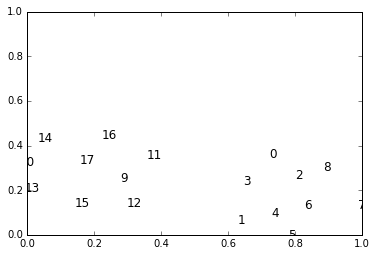

In [22]:
A = nx.planted_partition_graph(l=2, k=9, p_in=1, p_out =0.1)
labels = nx.draw_networkx_labels(A, pos=nx.spring_layout(A))

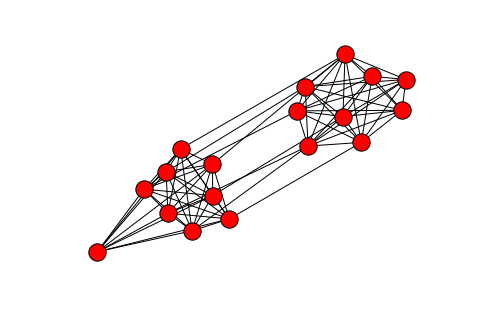

In [23]:
nx.draw(A)

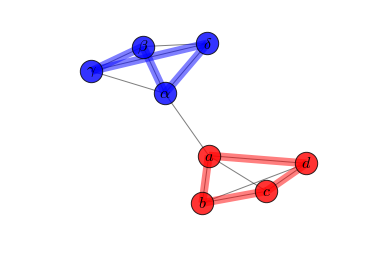

In [29]:
import matplotlib.pyplot as plt

import networkx as nx

G=nx.nx.planted_partition_graph(l=2, k=4, p_in=1, p_out =0.15)
pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,
                       nodelist=[0,1,2,3],
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=[4,5,6,7],
                       node_color='b',
                       node_size=500,
                   alpha=0.8)

# edges
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
nx.draw_networkx_edges(G,pos,
                       edgelist=[(0,1),(1,2),(2,3),(3,0)],
                       width=8,alpha=0.5,edge_color='r')
nx.draw_networkx_edges(G,pos,
                       edgelist=[(4,5),(5,6),(6,7),(7,4)],
                       width=8,alpha=0.5,edge_color='b')


# some math labels
labels={}
labels[0]=r'$a$'
labels[1]=r'$b$'
labels[2]=r'$c$'
labels[3]=r'$d$'
labels[4]=r'$\alpha$'
labels[5]=r'$\beta$'
labels[6]=r'$\gamma$'
labels[7]=r'$\delta$'
nx.draw_networkx_labels(G,pos,labels,font_size=16)

plt.axis('off')
plt.savefig("labels_and_colors.png") # save as png
plt.show() 